<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Predicting Shots Made Per Game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties — ridge, lasso, and elastic net — to try and predict how many shots Kobe Bryant made per game during his career.

The Kobe Shots data set contains hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model, considering the limited number of observations (games) we have available. Plus, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute. It may be worthwhile to only use a portion of the data to perform these calculations, especially if you've experienced kernel issues in the past.

---

### 1) Load packages and data.

BUT FIRST!  What exactly are these beta coeffcients we keep talking about? 

Beta coefficients in linear and logistic regression (which we learn about next week) is the value or measure of how strongly each predictor variable (each feature in the model) influences the dependent variable (your target/y variable).



In [1]:
import numpy as np
import pandas as pd


from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')

---

### 2) Examine the data.

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why might regularization be particularly useful for modeling this data?

In [3]:
print('Columns:', len(kobe.columns))

Columns: 645


In [4]:
kobe.shape

(1558, 645)

---

### 3) Create predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [5]:
print(kobe.columns[0:20])

# The columns contain various statistics for each game. 
# There is a column SHOTS_MADE that will be our target variable for prediction.
# This is good for regularization because there are so many columns (feature selection)
# and many of the columns represent similar things (multicollinearity)

Index(['SHOTS_MADE', 'AWAY_GAME', 'SEASON_OPPONENT:atl:1996-97',
       'SEASON_OPPONENT:atl:1997-98', 'SEASON_OPPONENT:atl:1999-00',
       'SEASON_OPPONENT:atl:2000-01', 'SEASON_OPPONENT:atl:2001-02',
       'SEASON_OPPONENT:atl:2002-03', 'SEASON_OPPONENT:atl:2003-04',
       'SEASON_OPPONENT:atl:2004-05', 'SEASON_OPPONENT:atl:2005-06',
       'SEASON_OPPONENT:atl:2006-07', 'SEASON_OPPONENT:atl:2007-08',
       'SEASON_OPPONENT:atl:2008-09', 'SEASON_OPPONENT:atl:2009-10',
       'SEASON_OPPONENT:atl:2010-11', 'SEASON_OPPONENT:atl:2011-12',
       'SEASON_OPPONENT:atl:2012-13', 'SEASON_OPPONENT:atl:2013-14',
       'SEASON_OPPONENT:atl:2014-15'],
      dtype='object')


In [6]:
y = kobe.SHOTS_MADE.values    
X = kobe.iloc[:,1:]

# Initialize the StandardScaler object.
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs = ss.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are only different sizes because of the scale of predictor variables,
# the regularization term can't determine which betas are more/less 
# important based on their size.

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [7]:
lr = LinearRegression()

lr_scores = cross_val_score(lr, Xs, y, cv=10)

print(lr_scores)
print(np.mean(lr_scores))

[ -1.72613407e+29  -3.90952389e+28  -1.94599989e+28  -1.91132340e+28
  -1.26335670e+28  -9.09558160e+27  -6.77796170e+27  -1.26373928e+28
  -2.27342858e+28  -4.70307387e+28]
-3.61191406917e+28


In [8]:
# The mean R^2 is extremely negative. All of the R^2 scores are negative in cross-validation.# The m 
# The linear regression is performing far worse than the baseline on the testing sets.
# It's probably dramatically overfitting, and the redundant variables are affecting
# the coefficients in unusual ways.

---

### 5) Find an optimal value for the ridge regression alpha using `RidgeCV`.

Go to the documentation and [read how RidgeCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

> *Hint: Once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that ridge performs best when searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit.


In [9]:
%time
ridge_alphas = np.logspace(0, 5, 100)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.7 µs
599.484250319


---

### 6) Cross-validate the ridge regression $R^2$ with the optimal alpha.

Is it better than the linear regression? If so, why might this be?

In [10]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[ 0.60354951  0.53005223  0.48600605  0.58938973  0.51686265  0.52833247
  0.52790845  0.40875612  0.38700321  0.43969737]
0.501755780272


In [20]:
# It's vastly better than the linear regression. 
# There's likely so much multicollinearity in the data that linear regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

In [50]:
ridge.fit(Xs, y)

Ridge(alpha=599.48425031894089, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [54]:
ridge.fit(Xs, y)

ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef': abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(10)

,abs_coef,coef,variable
574,0.278986,0.278986,SHOT_TYPE:2pt_field_goal
579,0.264177,0.264177,COMBINED_SHOT_TYPE:jump_shot
569,0.261213,0.261213,SHOT_ZONE_AREA:center(c)
556,0.237277,0.237277,SHOT_ZONE_RANGE:16-24_ft.
577,0.232823,0.232823,COMBINED_SHOT_TYPE:dunk
582,0.227098,0.227098,SECONDS_REMAINING
584,0.223821,0.223821,PERIOD
566,0.220295,0.220295,SHOT_ZONE_BASIC:restricted_area
565,0.218809,0.218809,SHOT_ZONE_BASIC:mid-range
573,0.180409,0.180409,SHOT_ZONE_AREA:right_side(r)


---

### 7) Find an optimal value for lasso regression alpha using `LassoCV`.

Go to the documentation and [read how LassoCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It is very similar to `RidgeCV`.

> *Hint: Again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that lasso, unlike ridge, performs best when searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide what alphas to use itself by setting the keyword argument `n_alphas=` to however many alphas you want it to search over. We recommend letting scikit-learn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if it's working, set `verbose =1`._

In [40]:
%time
optimal_lasso = LassoCV(n_alphas=200, cv=5)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs
0.0576483925252


---

### 8) Cross-validate the lasso $R^2$ with the optimal alpha.

Is it better than the linear regression? Is it better than ridge? What do the differences in results imply about the issues with the data set?

In [41]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[ 0.62297435  0.52601665  0.53757036  0.61520994  0.54344862  0.55467151
  0.53063549  0.44706724  0.46407576  0.50949776]
0.535116768642


In [24]:
# The lasso performs similarly but slightly better than the ridge.
# Lasso deals primarily with the feature selection of valuable variables,
# eliminating ones that aren't useful. This also takes care of multicollinearity,
# but in a different way: It'll choose the "best" of the correlated variables
# and zero out the redundant ones.
# There may also be useless variables in the data, which it simply gets rid
# of entirely.

---

### 9) Look at the coefficients for variables in the lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original data set are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** If you only fit the lasso within `cross_val_score`, you'll have to refit it outside of that function to pull out the coefficients.

In [43]:
lasso.fit(Xs, y)

Lasso(alpha=0.057648392525239053, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef': abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(100)

,abs_coef,coef,variable
579,1.262795,1.262795,COMBINED_SHOT_TYPE:jump_shot
574,0.832759,0.832759,SHOT_TYPE:2pt_field_goal
566,0.467598,0.467598,SHOT_ZONE_BASIC:restricted_area
611,0.282456,-0.282456,ACTION_TYPE:jump_shot
577,0.278330,0.278330,COMBINED_SHOT_TYPE:dunk
575,0.139793,0.139793,SHOT_TYPE:3pt_field_goal
612,0.139640,-0.139640,ACTION_TYPE:layup_shot
423,0.139575,0.139575,SEASON_OPPONENT:sac:1999-00
233,0.126999,0.126999,SEASON_OPPONENT:mem:2009-10
549,0.124477,-0.124477,SEASON:2015-16


In [28]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))


Percent variables zeroed out: 0.306803594352


---

### 10) Find an optimal value for elastic net regression alpha using `ElasticNetCV`.

Go to the documentation and [read how ElasticNetCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note that here you'll be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: Strength of regularization.
- `l1_ratio`: Amount of ridge vs. lasso (0 = all ridge, 1 = all lasso).
    
Do not include 0 in the search for `l1_ratio` — it won't allow it and will break.

You can use `n_alphas` for the alpha parameters instead of setting your own values, which we highly recommend.

Also, be careful setting too many l1_ratios over cross-validation folds in your search. It can take a long time if you choose too many combinations and, for the most part, there are diminishing returns in this data.

In [56]:
ratios  = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=ratios, n_alphas=5, cv=2,
                            verbose=0)
optimal_enet.fit(Xs, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)


/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0830001083219
1.0


---

### 11) Cross-validate the elastic net $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the ridge and lasso regularized regressions?

In [57]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

[ 0.60500347  0.52643041  0.53918948  0.60872919  0.5491681   0.55397171
  0.52265992  0.44770406  0.46442362  0.52614891]
0.53434288777


In [ ]:
# It performs about the same as lasso, which is to be expected given the
# l1_ration approaching 1 (full lasso).

---

### 12. [Bonus] Compare the residuals for ridge and lasso visually.


In [58]:
ridge.fit(Xs, y)
lasso.fit(Xs, y)

Lasso(alpha=0.057648392525239053, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [59]:
# Model residuals:

ridge_resid = y - ridge.predict(Xs)
lasso_resid = y - lasso.predict(Xs)



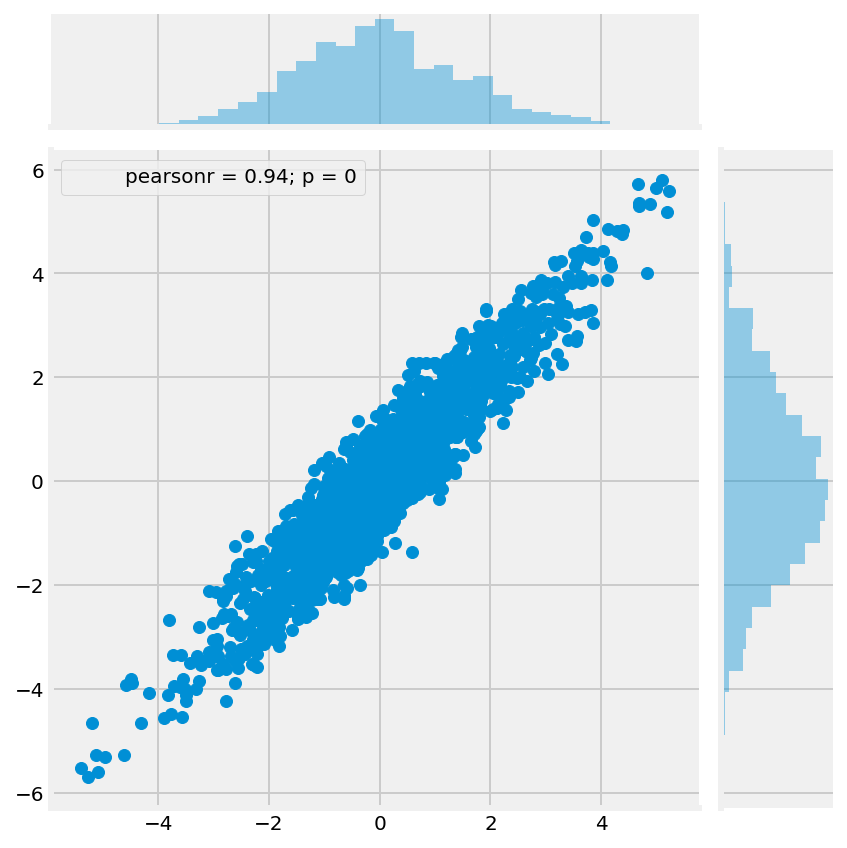

In [60]:
sns.jointplot(ridge_resid, lasso_resid)